In [1]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os
import sys

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

In [2]:
# MPC import
import numpy as np
from LinearMPC_deliverable_3_1.MPCVelControl import MPCVelControl
from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis
from src.vel_rocket_vis import plot_static_states_inputs


rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")


In [3]:
Ts = 0.05
sim_time = 20
H = 10
# x0 = np.zeros(12) # initial state
# x0[5] = np.deg2rad(30.0)   # ≈ 0.5236 
# x0[6] = 5.0  # initial vx
# x0[7] = 5.0  # initial vy
# x0[8] = 5.0  # initial vz# initial wy
#on doit changer un des parametres de xo pour mettre une vitesse dans la direction voulue 
# X -> Xo(6) = Vx, Y-> XO(7) = Vy, Z-> Xo(8) = Vz

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
xs, us = rocket.trim()
x0 = xs.copy()
x0[5] = np.deg2rad(30)
x0[6] = 5.0  # initial vx
x0[7] = 5.0  # initial vy
x0[8] = 5.0  # initial vz# initial wy
xs, us = rocket.trim()
print("us =", us)
print("Pdiff trim us[3] =", us[3])
mpc = MPCVelControl().new_controller(rocket, Ts, H)



t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, _ = rocket.simulate_control(
    mpc, sim_time, H, x0, method="linear"
)


vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(t_cl[:-1], x_cl[:, :-1], u_cl, T_ol=t_ol[..., :-1], X_ol=x_ol, U_ol=u_ol);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

us = [ 0.          0.         66.66666667  0.        ]
Pdiff trim us[3] = 0.0
['A', 'H', 'b']
['A', 'H', 'b']
Simulating time 0.00: u_x: [0.26179985]


c:\Users\SammD\anaconda3\envs\mpc2025\Lib\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


u_y: [-0.26180008]
u_z: [39.99999999]
u_roll: [-8.93100659]

Simulating time 0.05: u_x: [0.06890143]
u_y: [-0.26179802]
u_z: [40.00002993]
u_roll: [-7.75603584]

Simulating time 0.10: u_x: [-0.06285633]
u_y: [0.24880283]
u_z: [40.00001654]
u_roll: [-6.69581413]

Simulating time 0.15: u_x: [-0.11055388]
u_y: [0.26061868]
u_z: [40.00002446]
u_roll: [-5.7407089]

Simulating time 0.20: u_x: [-0.10598255]
u_y: [0.02668767]
u_z: [40.00001269]
u_roll: [-4.8816046]

 State alpha violation: 0.17 > 0.17, 
Simulating time 0.25: u_x: [-0.05148389]
u_y: [-0.01980346]
u_z: [40.00002094]
u_roll: [-4.11007457]

 State alpha violation: 0.17 > 0.17, 
Simulating time 0.30: u_x: [0.20697556]
u_y: [0.0117266]
u_z: [40.00001021]
u_roll: [-3.41842024]

 State beta violation: -0.17 < -0.17, 
Simulating time 0.35: u_x: [0.06175038]
u_y: [-0.00697744]
u_z: [40.00001966]
u_roll: [-2.79956701]

 State beta violation: -0.19 < -0.17, 
 State alpha violation: 0.17 > 0.17, 
Simulating time 0.40: u_x: [-0.00494758]
u_

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=399, step=2), IntSlider(value=0…

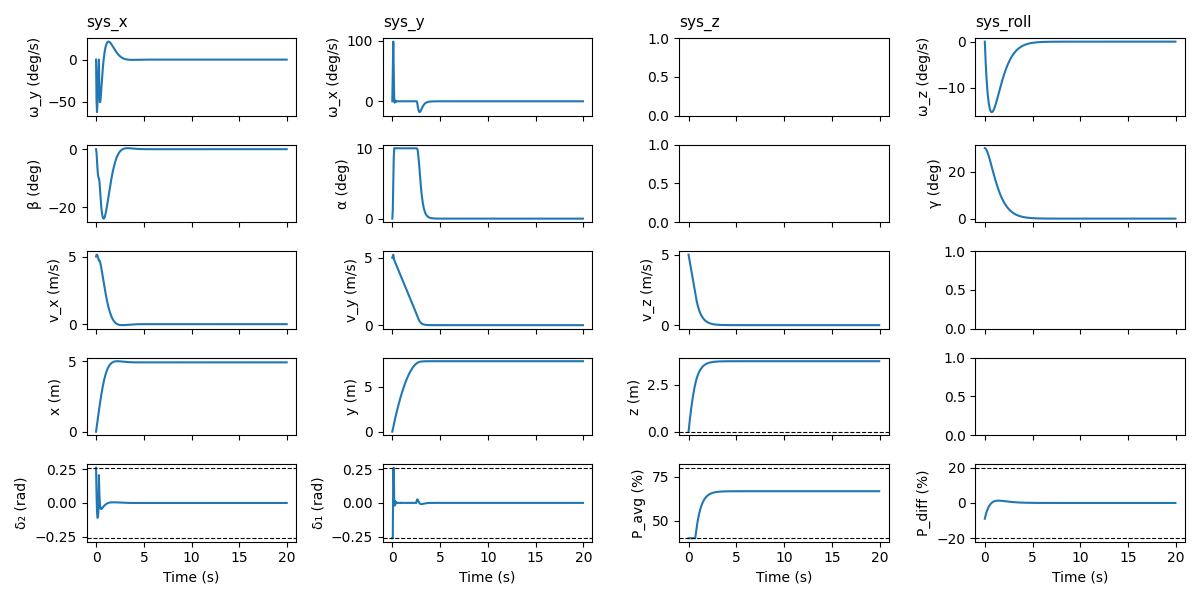

In [4]:
plot_static_states_inputs(
    T=t_cl[:-1],      # time for inputs
    X=x_cl[:, :-1],   # match the same length
    U=u_cl,           # DON'T slice
    Ref=None,
    type="vel"
)



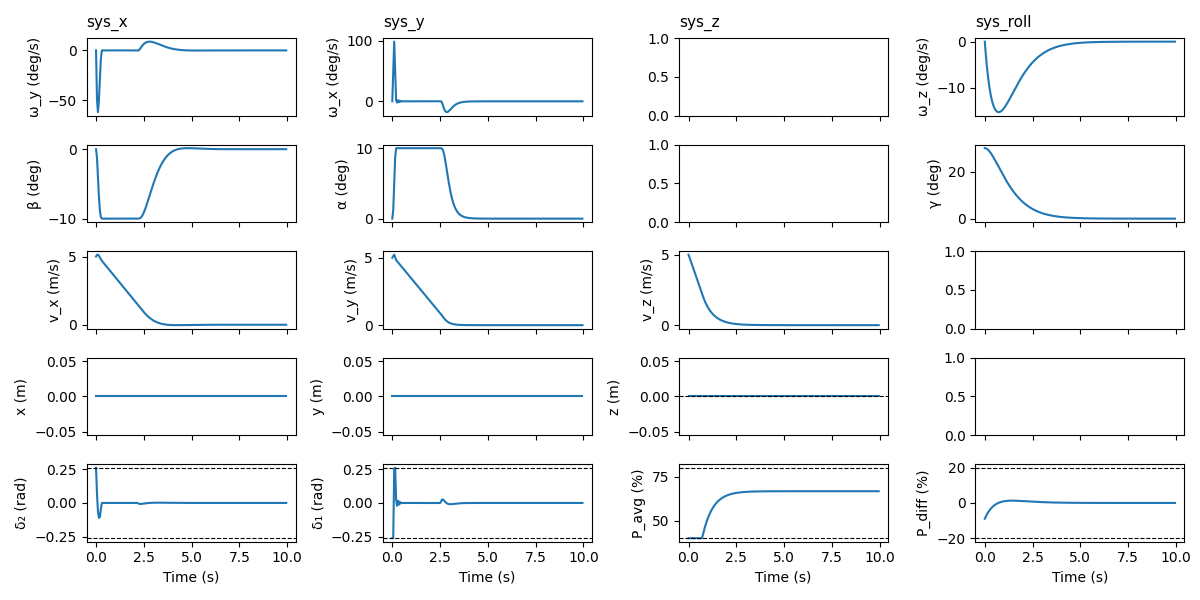

In [5]:
from src.vel_rocket_vis import plot_static_states_inputs

k = 0
T_ol = t_ol[:, k]      # shape (H+1,)
X_ol = x_ol[:, :, k]   # shape (12, H+1)
U_ol = u_ol[:, :, k]   # shape (4, H)

plot_static_states_inputs(
    T=T_ol[:-1],
    X=X_ol[:, :-1],
    U=U_ol,
    Ref=None,
    type="vel"
)
